<a href="https://colab.research.google.com/github/Aryan1320/Handwritten-Letter-Recognition/blob/main/Handwritten_Letter_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.EMNIST(
    root="./data",
    split="letters",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
    root="./data",
    split="letters",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

100%|██████████| 562M/562M [00:06<00:00, 92.3MB/s]


In [4]:
class LetterCNN(nn.Module):
    def __init__(self):
        super(LetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 26)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = LetterCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        labels = labels - 1  # Shift labels from 1–26 → 0–25

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 1170.6678
Epoch 2, Loss: 663.4709
Epoch 3, Loss: 543.2706


In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels - 1
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 92.81%


Saving H_1.png to H_1.png
Predicted Letter: H


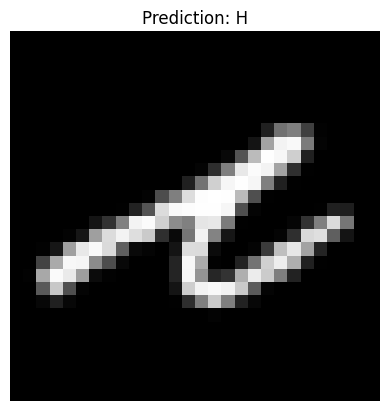

In [7]:
from google.colab import files
uploaded = files.upload()

def predict_letter(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((28, 28))
    img = np.array(img) / 255.0
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    return chr(predicted.item() + 65)

for file_name in uploaded.keys():
    prediction = predict_letter(file_name)
    print(f"Predicted Letter: {prediction}")

    img = Image.open(file_name)
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')
    plt.show()